# Case Study 1 : Collecting Data from Twitter

Due Date: September 22, **before the beginning of class at 6:00pm**

* ------------

<img src="https://upload.wikimedia.org/wikipedia/en/thumb/9/9f/Twitter_bird_logo_2012.svg/220px-Twitter_bird_logo_2012.svg.png">

In [ ]:
**TEAM Members:** Please EDIT this cell and add the names of all the team members in your team

    Melanie Jutras
    
    Debraj Roy
    
    Praneeth Nooli
    
    Rahul Ghadge
    
    Sushma Tayanna

**Required Readings:** 
* Chapter 1 and Chapter 9 of the book [Mining the Social Web](http://www.learndatasci.com/wp-content/uploads/2015/08/Mining-the-Social-Web-2nd-Edition.pdf) 
* The codes for [Chapter 1](http://bit.ly/1qCtMrr) and [Chapter 9](http://bit.ly/1u7eP33)


** NOTE **
* Please don't forget to save the notebook frequently when working in IPython Notebook, otherwise the changes you made can be lost.

*----------------------

# Problem 1: Sampling Twitter Data with Streaming API about a certain topic

* Select a topic that you are interested in, for example, "WPI" or "Lady Gaga"
* Use Twitter Streaming API to sample a collection of tweets about this topic in real time. (It would be recommended that the number of tweets should be larger than 200, but smaller than 1 million.
* Store the tweets you downloaded into a local file (txt file or json file) 

In [1]:
import twitter
import json
import pymongo

#--------------------------------------------------------------------------------------
# The purpose of oauth_login() function is
#    1. Login to the Twitter API
#    2. Return twitter handle necessary for its use in later functions

def oauth_login():
    # Had to go to http://twitter.com/apps/new to create an app and get values
    # for these credentials
    # See https://dev.twitter.com/docs/auth/oauth for more information 
    # on Twitter's OAuth implementation.
    
    CONSUMER_KEY = ''
    CONSUMER_SECRET =''
    OAUTH_TOKEN = ''
    OAUTH_TOKEN_SECRET = ''
    
    auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                               CONSUMER_KEY, CONSUMER_SECRET)
    
    twitter_api = twitter.Twitter(auth=auth)
    return twitter_api
#--------------------------------------------------------------------------------------
# The purpose of save_to_mongo() function is
#    1. Connect to the MongoDB server running on localhost
#    2. Get a reference to database specified in input paramter
#    3. Reference collection specified in input parameter
#    4. Save data to database and return IDs

def save_to_mongo(data, mongo_db, mongo_db_coll, **mongo_conn_kw):
    
    # Connects to the MongoDB server running on 
    # localhost:27017 by default
    
    client = pymongo.MongoClient(**mongo_conn_kw)
    
    # Get a reference to a particular database
    
    db = client[mongo_db]
    
    # Reference a particular collection in the database
    
    coll = db[mongo_db_coll]
    
    # Perform a bulk insert and  return the IDs
    return coll.insert_many(data)
#--------------------------------------------------------------------------------------
# The purpose of load_from_mongo() function is
#    1. Given the db and coll passed in, find data based on criteria if given
#    4. Load data from database and return cursor or item to user

def load_from_mongo(mongo_db, mongo_db_coll, return_cursor=False,
                    criteria=None, projection=None, **mongo_conn_kw):
    
    # Optionally, use criteria and projection to limit the data that is 
    # returned as documented in 
    # http://docs.mongodb.org/manual/reference/method/db.collection.find/
    
    # Consider leveraging MongoDB's aggregations framework for more 
    # sophisticated queries.
    
    client = pymongo.MongoClient(**mongo_conn_kw)
    db = client[mongo_db]
    coll = db[mongo_db_coll]
    
    if criteria is None:
        criteria = {}
    
    if projection is None:
        cursor = coll.find(criteria)
    else:
        cursor = coll.find(criteria, projection)

    # Returning a cursor is recommended for large amounts of data
    
    if return_cursor:
        return cursor
    else:
        return [ item for item in cursor ]



#--------------------------------------------------------------------------------------
# The purpose of the get_trends() function is:
#    1. Gather current world trends from twitter
#    2. Gather current US trends from twitter
#    3. Print the trends for viewing (TODO: Do we want to save trending data?)

def get_trends(twitter_api):
    
    # The Yahoo! Where On Earth ID for the entire world is 1.
    # See https://dev.twitter.com/docs/api/1.1/get/trends/place and
    # http://developer.yahoo.com/geo/geoplanet/

    WORLD_WOE_ID = 1
    US_WOE_ID = 23424977

    # Prefix ID with the underscore for query string parameterization.
    # Without the underscore, the twitter package appends the ID value
    # to the URL itself as a special case keyword argument.

    world_trends = twitter_api.trends.place(_id=WORLD_WOE_ID)
    us_trends = twitter_api.trends.place(_id=US_WOE_ID)


    print ('*** Here are the WORLD TRENDS :')
    print (json.dumps(world_trends, indent=1))
    print ('*** Here are the US TRENDS :')
    print (json.dumps(us_trends, indent=1))

#--------------------------------------------------------------------------------------
# OLD CODE - NO LONGER USED
# The purpose of the getPokemonGoTweets() function is:
#   1. Search twitter for tweets containing the search term '#PokemonGo'
#   2. Save any tweets retrieved in a file named 'pokemonresults.txt'
#
# This was the original function written to get PokemonGo tweets.  It is no longer
# being called by anyone, but was saved to show our first attempt using the polling API
# and writing results to a file rather than a database.

def getPokemonGoTweets(twitter_api):
    
       
    # Import unquote to prevent url encoding errors in next_results
    from urllib.parse import unquote

    # Set q to the topic of interest for CaseStudy1-Problem1, PokemonGo 

    q = '#PokemonGo' 

    count = 100

    # See https://dev.twitter.com/docs/api/1.1/get/search/tweets

    search_results = twitter_api.search.tweets(q=q, count=count)

    statuses = search_results['statuses']


    # Iterate through 5 more batches of results by following the cursor

    for _ in range(5):
        print ("Length of statuses", len(statuses))
        try:
            next_results = search_results['search_metadata']['next_results']
        except KeyError as e: # No more results when next_results doesn't exist
            break

        # Create a dictionary from next_results, which has the following form:
        # ?max_id=313519052523986943&q=NCAA&include_entities=1
        kwargs = dict([ kv.split('=') for kv in unquote(next_results[1:]).split("&") ])

        search_results = twitter_api.search.tweets(**kwargs)
        statuses += search_results['statuses']
        
    # Dump data to json file in json format    
    with open('pokemonresults.txt', 'w') as outfile:
        json.dump(statuses, outfile)  
    # Note: by opening file using 'with', no need to close() the file. It happens implicitly.
    

#--------------------------------------------------------------------------------------
# The purpose of the twitter_search() function is:
#   1. Search twitter for tweets containing the search term q, defaulting results=200
#      because oAuth users can "only" make 180 search queries per 15 minute interval
#
#   2. return statuses

def twitter_search(twitter_api, q, max_results=200, **kw):

    # See https://dev.twitter.com/docs/api/1.1/get/search/tweets and 
    # https://dev.twitter.com/docs/using-search for details on advanced 
    # search criteria that may be useful for keyword arguments
    
    # See https://dev.twitter.com/docs/api/1.1/get/search/tweets    
    search_results = twitter_api.search.tweets(q=q, count=100, **kw)
    
    statuses = search_results['statuses']
    
    # Iterate through batches of results by following the cursor until we
    # reach the desired number of results, keeping in mind that OAuth users
    # can "only" make 180 search queries per 15-minute interval. See
    # https://dev.twitter.com/docs/rate-limiting/1.1/limits
    # for details. A reasonable number of results is ~1000, although
    # that number of results may not exist for all queries.
    
    # Enforce a reasonable limit
    max_results = min(1000, max_results)
    
    for _ in range(10): # 10*100 = 1000
        try:
            next_results = search_results['search_metadata']['next_results']
        except KeyError as e: # No more results when next_results doesn't exist
            break
            
        # Create a dictionary from next_results, which has the following form:
        # ?max_id=313519052523986943&q=NCAA&include_entities=1
        kwargs = dict([ kv.split('=') 
                        for kv in next_results[1:].split("&") ])
        
        search_results = twitter_api.search.tweets(**kwargs)
        statuses += search_results['statuses']
        
        if len(statuses) > max_results: 
            break
            
    return statuses

        

#--------------------------------------------------------------------------------------
# The purpose of the mainDataGathering() function is:
#     1. Login to twitter and get api handle
#     1. Gather desired twitter data and save for future use

def mainDataGathering():
    
    twitter_api = oauth_login()
    print(twitter_api)
    
    # Search twitter for "#PokemonGo" tweets
    q = "#PokemonGo"

    # Use twitter streaming API
    twitter_stream = twitter.TwitterStream(auth=twitter_api.auth)
    
    # See https://dev.twitter.com/docs/streaming-apis
    #stream = twitter_stream.statuses.filter(track=q)
    
    
    #get_trends(twitter_api)

    #getPokemonGoTweets(twitter_api)
    
    # MongoDB---------------------------------------------------
    # Connects to the MongoDB server running on 
    # localhost:27017 by default
    
    #client = pymongo.MongoClient(**mongo_conn_kw)
    client = pymongo.MongoClient('localhost', 27017)
    
    # Get a reference to a particular database
    mongo_db = 'stream_results'
    db = client[mongo_db]
    
    # Reference a particular collection in the database
    mongo_db_coll = 'StreamingTweet'
    coll = db[mongo_db_coll]

    
    
    
    #results = twitter_search(twitter_api, q, max_results=10)
    stream = twitter_stream.statuses.filter(track=q)
    for tweet in stream:
        print(tweet['text'])  
        # Save results to MongoDB
        coll.insert_one(tweet)
        #save_to_mongo(stream, 'stream_results', 'StreamingTweet')

    # --------------------------------------------------------------------------------
    # This is an example of how to get some data from the database
    #
    #print('**** Load the DATABASE ***')
    #cursor = load_from_mongo('stream_results', q, return_cursor=True)
    #print('**** HERE is some data from the DATABASE ***')
    #for trend in cursor:
        # Print the text
        #print(trend['text'])
        # Print user and location
        #print(trend['user']['location'])
    

    

#--------------------------------------------------------------------------------------
# Call the mainDataGathering() function to perform actions needed for 
# DS501 CaseStudy 1 Problem 1 : Sampling twitter data with streaming api about a topic

mainDataGathering()

#--------------------------------------------------------------------------------------
# Test that the mainDataGathering() worked by displaying a sample result from the file
# This is not necessary and can be commented out if display is not desired here...

#print ("*** Sample PokemonGo output : ")
# Get one sample search result from file
#with open('pokemonresults.txt','r') as json_data:
#    json_statuses = json.load(json_data)
#    print(json.dumps(json_statuses[0], indent=4))
# Note: by opening file using 'with', no need to close() the file. It happens implicitly.

# q = "#PokemonGo"
#load_from_mongo('stream_results', q)



Gen 2 evo predictions https://t.co/asLFh0m1ep #PokemonGo #PokemonGo
RT @OMGitsAliA: I have a #PokemonGO PLUS to giveaway to one of YOU! 😍🙌🏻 Just RETWEET + FOLLOW for a chance to win. Good luck! 💙 https://t.c…
A wild Bulbasaur appeared!
It will be Finley Golf Course until 9:42 AM.
https://t.co/yLeOKYdZSe #Bulbasaur #FinleyGolfCourse #PokemonGo
Thought I'd show off my precious POS https://t.co/Qjx0Zs9gtF #PokemonGo #PokemonGo
[Question] About Nidoqueen, Nidoking and their primary/secondary types... https://t.co/ew3vsP5P9J #PokemonGo #PokemonGo
#VideoOfTheDay Reality GO - BiTS #BiTS #Arte #Ingress #PokemonGo https://t.co/dSwabe6NDz via @BiTSmagazine
Soy Hypno. Descubre que #PokemonGO eres! ENTRA: https://t.co/zmSqt84XF7 https://t.co/yOHs4SwJjV
Absolutely. #pokemonGo #TeamMystic @TeamMysticPGO @MysticPGO https://t.co/8mIurFwf8A
A wild Rapidash has appeared! Available until 06:43:39am (14m 49s). #PokemonGo #PokeSantaMonica https://t.co/m6An0ytnHV
RT @OMGitsAliA: I have a #PokemonGO PLUS to 

KeyboardInterrupt: 

# Report some statistics about the tweets you collected 

* The topic of interest: < #PokemonGo >


* The total number of tweets collected:  < 5391 >

*-----------------------

# Problem 2: Analyzing Tweets and Tweet Entities with Frequency Analysis

**1. Word Count:** 
* Use the tweets you collected in Problem 1, and compute the frequencies of the words being used in these tweets. 
* Plot a table of the top 30 words with their counts

**** Load the DATABASE ***
**** HERE is some data from the DATABASE ***
[
 "Gen 2 evo predictions https://t.co/asLFh0m1ep #PokemonGo #PokemonGo",
 "RT @OMGitsAliA: I have a #PokemonGO PLUS to giveaway to one of YOU! \ud83d\ude0d\ud83d\ude4c\ud83c\udffb Just RETWEET + FOLLOW for a chance to win. Good luck! \ud83d\udc99 https://t.c\u2026",
 "A wild Bulbasaur appeared!\nIt will be Finley Golf Course until 9:42 AM.\nhttps://t.co/yLeOKYdZSe #Bulbasaur #FinleyGolfCourse #PokemonGo",
 "Thought I'd show off my precious POS https://t.co/Qjx0Zs9gtF #PokemonGo #PokemonGo",
 "[Question] About Nidoqueen, Nidoking and their primary/secondary types... https://t.co/ew3vsP5P9J #PokemonGo #PokemonGo"
]
[
 "OMGitsAliA",
 "BiTSmagazine",
 "TeamMysticPGO",
 "MysticPGO",
 "OMGitsAliA"
]
[
 "PokemonGo",
 "PokemonGo",
 "PokemonGO",
 "Bulbasaur",
 "FinleyGolfCourse"
]
[
 "Gen",
 "2",
 "evo",
 "predictions",
 "https://t.co/asLFh0m1ep"
]
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jutra

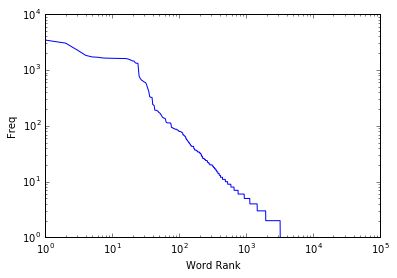

In [7]:
#----------------------------------------------
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import json
import pymongo

from prettytable import PrettyTable

mongo_db = 'stream_results'
mongo_db_coll = 'StreamingTweet'


# --------------------------------------------------------------------------------
# This is an example of how to get some data from the database
#
print('**** Load the DATABASE ***')
#cursor = load_from_mongo('stream_results', 'twitter', return_cursor=True)
# Connects to the MongoDB server running on 
# localhost:27017 by default
    
client = pymongo.MongoClient()
    
# Get a reference to a particular database
    
db = client[mongo_db]
    
# Reference a particular collection in the database
coll = db[mongo_db_coll]

cursor = coll.find({})


print('**** HERE is some data from the DATABASE ***')

#for trend in cursor:
    #print(trend['text'])
    #print(trend['user']['location'])
    

     
# This code is based on Example #10-13 in Chapter 9 of Mining the Social Web
    


curr_tweet_texts = [ curr_tweet['text'] 
                     for curr_tweet in cursor ]

cursor = coll.find({})

screen_names = [ user_mention['screen_name'] 
                 for curr_tweet in cursor
                     for user_mention in curr_tweet['entities']['user_mentions'] ]

cursor = coll.find({})

hashtags = [ hashtag['text'] 
             for curr_tweet in cursor
                 for hashtag in curr_tweet['entities']['hashtags'] ]

# Compute a collection of all words from all tweets
words = [ w 
          for t in curr_tweet_texts 
              for w in t.split() ]

# Explore the first 5 items for each...

print (json.dumps(curr_tweet_texts[0:5], indent=1))
print (json.dumps(screen_names[0:5], indent=1)) 
print (json.dumps(hashtags[0:5], indent=1))
print (json.dumps(words[0:5], indent=1))

#-----------------------------------------------------------------------------
# TRY to get rid of STOPWORDS
#
import nltk
# Download nltk packages used in this example
nltk.download('stopwords')
nltk.download('tokenizers/punkt/english.pickle')

stop_words = nltk.corpus.stopwords.words('english') + [
 '.',
 ',',
 '--',
 '\'s',
 '?',
 ')',
 '(',
 ':',
 '\'',
 '\'re',
 '"',
 '-',
 '}',
 '{',
 u'—',
 ]

#-----------------------------------------------
'''
cursor = coll.find({})
for item in cursor:
 sentences = nltk.tokenize.sent_tokenize(item['text'])
 new_words = [w.lower() for sentence in sentences for w in
              nltk.tokenize.word_tokenize(sentence)]
 fdist = nltk.FreqDist(words)
 # Basic stats
 num_words = sum([i[1] for i in fdist.items()])
 num_unique_words = len(fdist.keys())
 # Hapaxes are words that appear only once
 #num_hapaxes = len(fdist.hapaxes())
 top_10_words_sans_stop_words = [w for w in fdist.items() if w[0]
                                 not in stop_words][:30]
 
 #print '\tNum Sentences:'.ljust(25), len(sentences)
 print ('\tNum Words:'.ljust(25), num_words)
 print ('\tNum Unique Words:'.ljust(25), num_unique_words)
 #print '\tNum Hapaxes:'.ljust(25), num_hapaxes 
 print ('\tTop 30 Most Frequent Words (sans stop words):\n\t\t', \
        '\n\t\t'.join(['%s (%s)'
        % (w[0], w[1]) for w in top_10_words_sans_stop_words]))
 print()
 '''
#-----------------------------------------------------------------------------


from collections import Counter

print()
print('*** And here are the TOP 30 : ')

for item in [words]:
    pt = PrettyTable(field_names=['Words', 'Count'])
    c = Counter(item)
    #print (c.most_common()[:30]) # top 30
    [ pt.add_row(kv) for kv in c.most_common()[:30] ]
    pt.align['Words'], pt.align['Count'] = 'l', 'r'
    print(pt)

word_counts = sorted(Counter(words).values(), reverse = True)

plt.loglog(word_counts)
plt.ylabel("Freq")
plt.xlabel("Word Rank")


**2. Find the most popular tweets in your collection of tweets**

Please plot a table of the top 10 tweets that are the most popular among your collection, i.e., the tweets with the largest number of retweet counts.


+-------+--------------+----------------------------------------------------+
| Count | Screen Name  | Text                                               |
+-------+--------------+----------------------------------------------------+
| 38760 | PokemonGoApp | RT @PokemonGoApp: #PokemonGO Team Leaders          |
|       |              | revealed! Team Valor: Candela. Team Mystic:        |
|       |              | Blanche. Team Instinct: Spark.                     |
|       |              | https://t.co/j05H5K0tfY                            |
| 26316 | OMGitsAliA   | RT @OMGitsAliA: I have a #PokemonGO PLUS to        |
|       |              | giveaway to one of YOU! 😍🙌🏻 Just RETWEET + FOLLOW  |
|       |              | for a chance to win. Good luck! 💙 https://t.c…     |
| 26315 | OMGitsAliA   | RT @OMGitsAliA: I have a #PokemonGO PLUS to        |
|       |              | giveaway to one of YOU! 😍🙌🏻 Just RETWEET + FOLLOW  |
|       |              | for a chance to win. Good luck! 💙 https

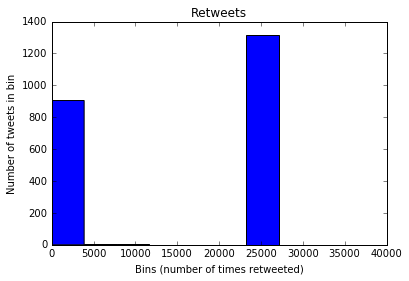

In [3]:
#----------------------------------------------
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary


# See Example 10 Ch9

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import json 
import pymongo 
from prettytable import PrettyTable

mongo_db = 'stream_results' 
mongo_db_coll = 'StreamingTweet'

# --------------------------------------------------------------------------------
#This is an example of how to get some data from the database 
# print('**** Load the DATABASE ***') 
#cursor = load_from_mongo('stream_search_results', 'twitter', return_cursor=True) 
# Connects to the MongoDB server running on 
# localhost:27017 by default     
client = pymongo.MongoClient()     
# Get a reference to a particular database     
db = client[mongo_db]     
# Reference a particular collection in the database 
coll = db[mongo_db_coll]
cursor = coll.find({})
retweets = []
retweets = [             
    # Store out a tuple of these three values ...             
    (status['retweeted_status']['retweet_count'],              
     status['retweeted_status']['user']['screen_name'],              
     status['text'])                         
     # ... for each status ...             
    for status in cursor                        
    # ... so long as the status meets this condition.                 
    #if status.has_key('retweeted_status') 
        if 'retweeted_status' in status
    ]
# Slice off the first 5 from the sorted results and display each item in the tuple
pt = PrettyTable(field_names=['Count', 'Screen Name', 'Text']) 
[ pt.add_row(row) for row in sorted(retweets, reverse=True)[:10] ] 
pt.max_width['Text'] = 50 
pt.align= 'l' 
print (pt)

# Using underscores while unpacking values in
# a tuple is idiomatic for discarding them

counts = [count for count, _, _ in retweets]

plt.hist(counts)
plt.title("Retweets")
plt.xlabel('Bins (number of times retweeted)')
plt.ylabel('Number of tweets in bin')

print (counts)








**3. Find the most popular Tweet Entities in your collection of tweets**

Please plot a table of the top 10 hashtags, top 10 user mentions that are the most popular in your collection of tweets.

In [ ]:
#----------------------------------------------
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary


# Example 14 Ch9
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import json 
import pymongo 
from prettytable import PrettyTable 

mongo_db = 'stream_results' 
mongo_db_coll = 'StreamingTweet' 

# -------------------------------------------------------------------------------- 
# This is an example of how to get some data from the database 
print('**** Load the DATABASE ***') 
#cursor = load_from_mongo('stream_search_results', 'twitter', return_cursor=True) 
# Connects to the MongoDB server running on # localhost:27017 by default      
client = pymongo.MongoClient()      
# Get a reference to a particular database      
db = client[mongo_db]      
# Reference a particular collection in the database 
coll = db[mongo_db_coll] 
cursor = coll.find({}) 
print('**** HERE is some data from the DATABASE ***')

#for trend in cursor:     

#print(trend['text'])     
#print(trend['user']['location'])            
# This code is based on Example #10-13 in Chapter 9 of Mining the Social Web      
curr_tweet_texts = [ curr_tweet['text']                      
                    for curr_tweet in cursor ] 
cursor = coll.find({}) 
screen_names = [ user_mention['screen_name']                  
                    for curr_tweet in cursor                      
                        for user_mention in curr_tweet['entities']['user_mentions'] ] 
cursor = coll.find({}) 
hashtags = [ hashtag['text']              
            for curr_tweet in cursor                  
                for hashtag in curr_tweet['entities']['hashtags'] ] 
# Compute a collection of all words from all tweets 
words = [ w           
          for t in curr_tweet_texts               
             for w in t.split() ]

# Explore the first 5 items for each... 
print (json.dumps(curr_tweet_texts[0:5], indent=1)) 
print (json.dumps(screen_names[0:5], indent=1)) 
print (json.dumps(hashtags[0:5], indent=1)) 
print (json.dumps(words[0:5], indent=1)) 
from collections import Counter 
print() 
print('*** And here are the TOP 30 : ') 
'''for item in [words]:     pt = PrettyTable(field_names=['Words', 'Count'])     c = Counter(item)     #print (c.most_common()[:30]) # top 30     [ pt.add_row(kv) for kv in c.most_common()[:30] ]     pt.align['Words'], pt.align['Count'] = 'l', 'r'     print(pt)''' 
for label, data in (
                    ('Screen Name', screen_names),                     
                    ('Hashtag', hashtags)):    
    pt = PrettyTable(field_names=[label, 'Count'])     
    c = Counter(data)     
    [ pt.add_row(kv) for kv in c.most_common()[:30] ]     
    pt.align[label], pt.align['Count'] = 'l', 'r' # Set column alignment     
    



* ------------------------

# Problem 3: Getting "All" friends and "All" followers of a popular user in twitter


* choose a popular twitter user who has many followers, such as "ladygaga".
* Get the list of all friends and all followers of the twitter user.
* Plot 20 out of the followers, plot their ID numbers and screen names in a table.
* Plot 20 out of the friends (if the user has more than 20 friends), plot their ID numbers and screen names in a table.

In [85]:
#--------------------------------------------------------------------------------------
# The purpose of this code is to get "all" friends and "all" followers of a popular
# twitter user.  This code is based on Example 19 in Chapter 9 of the book, Mining the
# Social Web.

from functools import partial
from sys import maxsize
from prettytable import PrettyTable


import sys
import time
from urllib.error import URLError
from http.client import BadStatusLine
#import json
#import twitter

def make_twitter_request(twitter_api_func, max_errors=10, *args, **kw): 
    
    # A nested helper function that handles common HTTPErrors. Return an updated
    # value for wait_period if the problem is a 500 level error. Block until the
    # rate limit is reset if it's a rate limiting issue (429 error). Returns None
    # for 401 and 404 errors, which requires special handling by the caller.
    def handle_twitter_http_error(e, wait_period=2, sleep_when_rate_limited=True):
    
        if wait_period > 3600: # Seconds
            print ('Too many retries. Quitting.', file = sys.stderr)
            raise e
    
        # See https://dev.twitter.com/docs/error-codes-responses for common codes
    
        if e.e.code == 401:
            print ('Encountered 401 Error (Not Authorized)', file = sys.stderr)
            return None
        elif e.e.code == 404:
            print ('Encountered 404 Error (Not Found)', file = sys.stderr)
            return None
        elif e.e.code == 429: 
            print ('Encountered 429 Error (Rate Limit Exceeded)', file = sys.stderr)
            if sleep_when_rate_limited:
                print ("Retrying in 15 minutes...ZzZ...", file = sys.stderr)
                sys.stderr.flush()
                time.sleep(60*15 + 5)
                print ('...ZzZ...Awake now and trying again.', file = sys.stderr)
                return 2
            else:
                raise e # Caller must handle the rate limiting issue
        elif e.e.code in (500, 502, 503, 504):
            print ('Encountered %i Error. Retrying in %i seconds' % \
                (e.e.code, wait_period), file = sys.stderr)
            time.sleep(wait_period)
            wait_period *= 1.5
            return wait_period
        else:
            raise e

    # End of nested helper function
    
    wait_period = 2 
    error_count = 0 

    while True:
        try:
            return twitter_api_func(*args, **kw)
        except twitter.api.TwitterHTTPError as e:
            error_count = 0 
            wait_period = handle_twitter_http_error(e, wait_period)
            if wait_period is None:
                return
        except URLError as e:
            error_count += 1
            time.sleep(wait_period)
            wait_period *= 1.5
            print ("URLError encountered. Continuing.", file = sys.stderr)
            if error_count > max_errors:
                print ("Too many consecutive errors...bailing out.", file = sys.stderr)
                raise
        except BadStatusLine as e:
            error_count += 1
            time.sleep(wait_period)
            wait_period *= 1.5
            print ("BadStatusLine encountered. Continuing.", file = sys.stderr)
            if error_count > max_errors:
                print ("Too many consecutive errors...bailing out.", file = sys.stderr)
                raise
                
#--------------------------------------------------------------------------------------
# The purpose of the get_friends_followers_ids() function is to use the screen_name of
# the twitter user passed in to find all friends and followers, find the intersection of
# the two lists and then to print 20 friends, print 20 followers and print the mutual list.
#

def get_friends_followers_ids(twitter_api, screen_name=None, user_id=None,
                              friends_limit=maxsize, followers_limit=maxsize):
    
    # Must have either screen_name or user_id (logical xor)
    assert (screen_name != None) != (user_id != None), \
    "Must have screen_name or user_id, but not both"
    
    # See https://dev.twitter.com/docs/api/1.1/get/friends/ids and
    # https://dev.twitter.com/docs/api/1.1/get/followers/ids for details
    # on API parameters
    
    # Use partial pattern to make it more convenient to set up initial parameters here for function calls later
    get_friends_ids = partial(make_twitter_request, twitter_api.friends.ids, 
                              count=5000)
                              
    get_followers_ids = partial(make_twitter_request, twitter_api.followers.ids, 
                               count=5000)

    friends_ids, followers_ids = [], []
    
    for twitter_api_func, limit, ids, label in [
                    [get_friends_ids, friends_limit, friends_ids, "friends"], 
                    [get_followers_ids, followers_limit, followers_ids, "followers"]
                ]:
        
        if limit == 0: continue
        
        cursor = -1
        while cursor != 0:
        
            # Use make_twitter_request via the partially bound callable...
            if screen_name: 
                response = twitter_api_func(screen_name=screen_name, cursor=cursor)
            else: # user_id
                response = twitter_api_func(user_id=user_id, cursor=cursor)

            if response is not None:
                ids += response['ids']
                cursor = response['next_cursor']
        
            print ('Fetched {0} total {1} ids for {2}'.format(len(ids), 
                                                    label, (user_id or screen_name)), file = sys.stderr)
        
            # XXX: You may want to store data during each iteration to provide an 
            # an additional layer of protection from exceptional circumstances
        
            if len(ids) >= limit or response is None:
                break

    # Do something useful with the IDs, like store them to disk...
    
    # Dump freinds and followers data to json file in json format    
    with open('friends_ids.txt', 'w') as friends_outfile, open('followers_ids.txt', 'w') as followers_outfile:
        json.dump(friends_ids, friends_outfile)  
        json.dump(followers_ids, followers_outfile)
   



    # Note: by opening file using 'with', no need to close() the file. It happens implicitly.
    
    # Use python to get the intersection of the friends_ids and followers_ids
    intersect_ids = list(set(friends_ids) & set(followers_ids))

    print ("*** HERE are ids of mutual friends followers of ", famous_person, " *** ")
    print (intersect_ids)

    # Dump intersection data to json file in json format        
    with open('intersect_ids.txt', 'w') as intersect_ff_outfile:
        json.dump(intersect_ids, intersect_ff_outfile)
    
    # Note: by opening file using 'with', no need to close() the file. It happens implicitly.

    return friends_ids[:friends_limit], followers_ids[:followers_limit]


twitter_api = oauth_login()

famous_person = "@JohnHanke"
num_friends = 22
num_followers  = 22

friends_ids, followers_ids = get_friends_followers_ids(twitter_api, 
                                                       screen_name=famous_person, 
                                                       friends_limit=num_friends, 
                                                       followers_limit=num_followers)



#print ("*** HERE are ", num_friends, " ids of friends of ", famous_person, " *** ")
#print (friends_ids)
#print ("*** HERE are ", num_followers, " ids of followers of ", famous_person, " *** ")
#print (followers_ids)

#print ()
#print ("*** Let's see them in Pretty Tables ! Doesn't this look Better ? *** ")
#print ()

#--------------------------------------------------------------------------------------
# Prepare and print Pretty Table for FRIENDS

friend_user_objects = twitter_api.users.lookup(user_id = json.dumps(friends_ids))

fr_ids = [ fr['id'] 
           for fr in friend_user_objects ]
    
fr_names = [ fr['screen_name'] 
             for fr in friend_user_objects ]
    
pt = PrettyTable()
pt.add_column("Friend ID", fr_ids)
pt.add_column("Friend Screen Name", fr_names)
    
pt.align = 'r'
print(pt)

#--------------------------------------------------------------------------------------
# Prepare and print Pretty Table for FOLLOWERS

follower_user_objects = twitter_api.users.lookup(user_id = json.dumps(followers_ids))

f_ids = [ fr['id'] 
           for fr in follower_user_objects ]
    
f_names = [ fr['screen_name'] 
             for fr in follower_user_objects ]
    
pt = PrettyTable()
pt.add_column("Follower ID", f_ids)
pt.add_column("Follower Screen Name", f_names)
    
pt.align = 'r'
print(pt)
 


Fetched 327 total friends ids for @JohnHanke
Fetched 5000 total followers ids for @JohnHanke


*** HERE are ids of mutual friends followers of  @JohnHanke  *** 
[1724473160, 769080580302569473, 130379779, 18327902]
*** HERE are  22  ids of friends of  @JohnHanke  *** 
[2244340904, 816653, 1636590253, 769080580302569473, 1724473160, 37666984, 105912240, 6331462, 1394399438, 16303106, 20106796, 2227174303, 81285400, 2839430431, 21094279, 714975751, 69489820, 14188906, 96879107, 19511752, 631577690, 714249583853867009]
*** HERE are  22  ids of followers of  @JohnHanke  *** 
[403424548, 113594235, 577964386, 217434145, 4914835684, 759887823038214144, 4765106839, 720515406532714496, 778336178621800448, 2164467097, 778358394063388677, 232204464, 58844519, 1673113746, 2970697108, 1211273371, 778318908910477312, 2204146394, 1391281, 2726900475, 2696492256, 3279871050]

*** Let's see them in Pretty Tables ! Doesn't this look Better ? *** 

+--------------------+--------------------+
|          Friend ID | Friend Screen Name |
+--------------------+--------------------+
|             8166

* Compute the mutual friends within the two groups, i.e., the users who are in both friend list and follower list, plot their ID numbers and screen names in a table

In [48]:
#-------------------------------------------------------------------------------------------------------------------
# The intersection of the friends and followers ids collected in the above example were saved to a file.  
# Note : This operation was performed as a poll or a one time request which has a limit on count of 5000 by design.
from prettytable import PrettyTable

#print ("*** Intersection of friends and followers : ")
with open('intersect_ids.txt','r') as user_ids:
    common_user_ids = json.load(user_ids)
    common_users = twitter_api.users.lookup(user_id = common_user_ids)
 

# Dump data to json file in json format    
with open('intersect_users.txt', 'w') as outfile:
    json.dump(common_users, outfile)# Therefore, the intersection of the resulting sets is not actually the complete list of mutual friends/followers of @JohnHanke,
# rather it is an intersection of the two sets collected above.

  

# Print results
with open('intersect_users.txt', 'r') as json_user_data:
    json_users = json.load(json_user_data)
    
    # Print one to test
    # print(json.dumps(json_users[0]['screen_name'], indent=4))
    
    # Prepare and print Pretty Table
    mutual_ids = [ mutual_person['id'] 
                   for mutual_person in json_users ]
    
    mutual_names = [ mutual_person['screen_name'] 
                   for mutual_person in json_users ]
    
    pt = PrettyTable()
    pt.add_column("ID", mutual_ids)
    pt.add_column("Screen Name", mutual_names)
    
    pt.align = 'r'
    print(pt)
    
  


+--------------------+---------------+
|                 ID |   Screen Name |
+--------------------+---------------+
| 769080580302569473 |   AgentKodama |
|          130379779 | MichiganCorps |
+--------------------+---------------+


*------------------------

# Problem 4: Business question 

Run some additional experiments with your data to gain familiarity with the twitter data and twitter API.

* Come up with a business question that Twitter data could help answer.
* Decribe the business case.
* How could Twitter data help a company decide how to spend its resources.

In [18]:
#----------------------------------------------
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

import json
import pymongo

mongo_db = 'stream_results'
mongo_db_coll = 'StreamingTweet'

# Connects to the MongoDB server running on 
# localhost:27017 by default
    
client = pymongo.MongoClient()
    
# Get a reference to a particular database
    
db = client[mongo_db]
    
# Reference a particular collection in the database
coll = db[mongo_db_coll]

cursor = coll.find({})

# The following code utilizes GeoJSON for examining coordinates of a tweet (where they exist)
# The data file that is output can be used to view tweets on a map by geojson.io

tweets_with_coords = []

geo_data = {
    "type": "FeatureCollection",
    "features": []
    }
for tweet in cursor:
    if tweet.get('coordinates'):
        geo_json_feature = {
                            "type": "Feature",
                            "geometry": tweet['coordinates'],
                            "properties": {
                                           "text": tweet['text'],
                                           "created_at": tweet['created_at']
                                          }
                            }
        geo_data['features'].append(geo_json_feature)
        
        tweets_with_coords.append(tweet)
print("*** Found ", len(tweets_with_coords), " tweets with coordinates")
for item in tweets_with_coords:
    if 'pikachu' in item['text']:
        pikachu_list.append(item)
    
print ('*** Pikachu list')
print (pikachu_list)
    

# Save geo data
with open('geo_data.json', 'w') as outfile:
    json.dump(geo_data, outfile, indent=4)
    



*** Found  74  tweets with coordinates
*** Pikachu list
[{'in_reply_to_screen_name': None, 'contributors': None, 'in_reply_to_status_id_str': None, '_id': ObjectId('57e3dd50e168ef2db8676f0f'), 'timestamp_ms': '1474551121684', 'created_at': 'Thu Sep 22 13:32:01 +0000 2016', 'place': {'attributes': {}, 'bounding_box': {'coordinates': [[[22.13572, 44.386383], [22.13572, 52.379475], [40.227172, 52.379475], [40.227172, 44.386383]]], 'type': 'Polygon'}, 'id': '084d0d0155787e9d', 'name': 'Украина', 'full_name': 'Украина', 'url': 'https://api.twitter.com/1.1/geo/id/084d0d0155787e9d.json', 'country_code': 'UA', 'place_type': 'country', 'country': 'Украина'}, 'geo': {'coordinates': [50.45, 30.5233], 'type': 'Point'}, 'user': {'profile_text_color': '333333', 'utc_offset': 10800, 'followers_count': 61, 'profile_background_image_url': 'http://pbs.twimg.com/profile_background_images/492001365/267388-5184x3070.jpg', 'profile_background_tile': False, 'geo_enabled': True, 'url': 'http://vk.com/katrin.p

*-----------------
# Done

All set! 

** What do you need to submit?**

* **Notebook File**: Save this IPython notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. If you used "ipython notebook --pylab=inline" to open the notebook, all the figures and tables should have shown up in the notebook.


* **PPT Slides**: please prepare PPT slides (for 10 minutes' talk) to present about the case study . We will ask two teams which are randomly selected to present their case studies in class for this case study. 

* ** Report**: please prepare a report (less than 10 pages) to report what you found in the data.
    * What data you collected? 
    * Why this topic is interesting or important to you? (Motivations)
    * How did you analyse the data?
    * What did you find in the data? 
 
     (please include figures or tables in the report, but no source code)

Please compress all the files in a zipped file.


** How to submit: **

        Please submit through email to Prof. Paffenroth (rcpaffenroth@wpi.edu) *and* the TA Wen Liu (wliu3@wpi.edu).
        
** Note: Each team just needs to submits one submission **

# Grading Criteria:

** Totoal Points: 120 **


---------------------------------------------------------------------------
** Notebook:  **
    Points: 80


    -----------------------------------
    Qestion 1:
    Points: 20
    -----------------------------------
    
    (1) Select a topic that you are interested in.
    Points: 6 
    
    (2) Use Twitter Streaming API to sample a collection of tweets about this topic in real time. (It would be recommended that the number of tweets should be larger than 200, but smaller than 1 million. Please check whether the total number of tweets collected is larger than 200?
    Points: 10 
    
    
    (3) Store the tweets you downloaded into a local file (txt file or json file)
    Points: 4 
    
    
    -----------------------------------
    Qestion 2:
    Points: 20
    -----------------------------------
    
    1. Word Count

    (1) Use the tweets you collected in Problem 1, and compute the frequencies of the words being used in these tweets.
    Points: 4 

    (2) Plot a table of the top 30 words with their counts 
    Points: 4 
    
    2. Find the most popular tweets in your collection of tweets
    plot a table of the top 10 tweets that are the most popular among your collection, i.e., the tweets with the largest number of retweet counts.
    Points: 4 
    
    3. Find the most popular Tweet Entities in your collection of tweets

    (1) plot a table of the top 10 hashtags, 
    Points: 4 

    (2) top 10 user mentions that are the most popular in your collection of tweets.
    Points: 4 
    
    
    -----------------------------------
    Qestion 3:
    Points: 20
    -----------------------------------
    
    (1) choose a popular twitter user who has many followers, such as "ladygaga".
    Points: 4 

    (2) Get the list of all friends and all followers of the twitter user.
    Points: 4 

    (3) Plot 20 out of the followers, plot their ID numbers and screen names in a table.
    Points: 4 

    (4) Plot 20 out of the friends (if the user has more than 20 friends), plot their ID numbers and screen names in a table.
    Points: 4 
    
    (5) Compute the mutual friends within the two groups, i.e., the users who are in both friend list and follower list, plot their ID numbers and screen names in a table
    Points: 4 
  
    -----------------------------------
    Qestion 4:  Business question
    Points: 20
    -----------------------------------
        Novelty: 10
        Interestingness: 10
    -----------------------------------
    Run some additional experiments with your data to gain familiarity with the twitter data ant twitter API.  Come up with a business question and describe how Twitter data can help you answer that question.




---------------------------------------------------------------------------
** Report: communicate the results**
    Points: 20

(1) What data you collected?
    Points: 5 

(2) Why this topic is interesting or important to you? (Motivations)
    Points: 5 

(3) How did you analyse the data?
    Points: 5 

(4) What did you find in the data?
(please include figures or tables in the report, but no source code)
    Points: 5 



---------------------------------------------------------------------------
** Slides (for 10 minutes of presentation): Story-telling **
    Points: 20


1. Motivation about the data collection, why the topic is interesting to you.
    Points: 5 

2. Communicating Results (figure/table)
    Points: 10 

3. Story telling (How all the parts (data, analysis, result) fit together as a story?)
    Points: 5 

